# Distributional Reinforcement Learning: Practical Session

In [2]:
# import necessary libraries 
import numpy as np
import seaborn as sns

import torch
import gym

from matplotlib import pyplot as plt
from random import shuffle
from collections import deque
from variables import *

from IPython.display import YouTubeVideo
from dist_dqn import dist_dqn
from auxiliary import preproc_state, get_dist_plot
from trainer import trainer, lossfn, get_action_dqn, get_target_dist

import imageio

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


# Distributional Reinforcement Learning 


## The Expectation Revisited

We will very briefly discuss how to compute the expectation. Recall that the expectation is essentially the weighted average of each of the values in the sample space. Formally

$$\large \mathbb{E}[X] = \sum_{i=1}^{n}x_{i}p_{i},$$

where $\mathbb{E}[X]$ denotes the expected value of a random variable $X$, $x_{i}$ a given outcome and $p_{i}$ the probability of that outcome. 

In python, we can compute it as follows:

In [3]:
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0

for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print(expected_value)

18.4


A more succinct way, however, is to compute the expected value as the dot product of the possible outcomes and their corresponding probabilities. In Python, we can use the ``@`` operator. 

In [4]:
expected_value = probs @ outcomes
print(expected_value)

18.4


## The Bellman Equation Revisited

Most reinforcement learning algorithms determine the value of an action using the *Bellman* equation:

$$\large Q (x,a) = \mathbb{E}[R(x,a)] + \gamma \mathbb{E}[Q(X', A')],$$

where $Q (x,a)$ denotes the q-function of a state-action pair, $\gamma$ the discount factor and $Q(X', A')$ the value of the state and action at the next time step. 

## The *Distributional* Bellman Equation 

A key difference between "regular" reinforcement learning and distributional reinforcement learning (DRL) is that in DRL, we do not "collapse" the value estimate into one single number.

In distributional RL, we are interested in learning the *entire* **value distribution**, which we can formalise it as follows:



$$\large Z(x, a) = R(x,a) + \gamma Z(X', A'),$$



where $Z$ takes the place of $Q$. Note that $X' \sim  P(\cdot | (x, a))$ and $A' \sim  \pi (\cdot| X')$ are random variables and $\gamma$ is the discount term. 

We use $Z$ to make clear that we are talking about a *distribution* rather than a singular Q-value. Important to understand, moreover, is that by using $Z$ we seek to express the following:

- Randomness in the reward.

- Randomness in the transition.

- Randomness in the next-state value distribution. 

As such, in distributional reinforcement learning we do not estimate the value function, but seek to estimate the value distribution for a state-action pair. 

## The Categorical Algorithm 

### Context, Scenario and Gameplay

In distributional RL, instead of talking about the sample space (which can be infinite), we make use of a **support** set. The support is essentially the same as the sample space, but bounded on both sides. 

An essential part of distributional reinforcement learning entails *updating* a *projection* of the distributional Bellman equation. In this section, we will discuss and implement such an updating procedure. 


Consider the scenario where we start with a situation in which we have a *sample transition* $(x, a, r, x')$, where $x$ denotes the current state, $a$ the action that is taken, $r$ the reward of that action and $x'$ the next state the agent would go to by taking that action.. 

To make things a bit more concrete, we will implement an updating procedure with a specific setting in mind, the game of Freeway. Freeway is an Atari game where the goal is for a chicken to cross  a highway without being hit by a car. 

The reward structure of this game is as follows:


- We received +10 reward if the chicken successfully crosses the highway.

- If the game is lost (the chicken does not manage to cross the street within a certain amount of time), we get a reward of -10. 



- At all non-terminal steps, we get a reward of -1. We do this to make sure that the agent *acts* and does not wait for too long. 

Moreover, we have 3 possible actions:

- NOOP. No operation, do nothing.

- DOWN. Go down.

- UP. Go up. 

By means of a short illustration, consider the following clip:

<img src="img/freeway.gif" width="750" align="center">

**Quick sidenote:** Note that, at all times, we assume a that the agent follows a greedy policy. 

**Quick sidenote:** Also important to note here is that we will use a kind of Bayesian updating procedure, meaning that we update a initial distribution based on information we encounter from the environment (i.e. the rewards we get).

### The Algorithm 

We update the distribution in accordance with a simple updating rule. We start with a initial distribution and gradually update it to a **target distribution**. 


Here we will follow the approach proposed by Bellemare et.al. (2017) for **approximate distributional reinforcement learning**. We will implement a slightly *modified* version of their **Categorical Algorithm**.

The Categorical Algorithm (displayed below) takes a sample transition as its input ($x_{t}$, $a_{t}$, $r_{t}$, $x_{t+1}$), a discount factor ($\gamma_{t}$), a q-value function ($Q_{x_{t+1}. a}$), an optimal successor state ($a^{*}$) and an index tracker ($m_{i}$).

<img src="img/algorithm.png" alt="drawing" width="800"/>

The algorithm consists of two parts:

1. The first part computes the projection onto the support vector. This simply means that we locate, on the support vector, where the centre of mass lies. 

2. The second part, which determines how much probability will be redistributed from the other points on the support to $\hat{T}z_{j}$ and to neighboring points.

**Quick sidenote:** Note that we will not implement the cross-entropy loss in this notebook. If you are interested in its implementation, please have a look at the function ``lossfn`` in the ``trainer.py``-file. 

### The Support and Probability Vectors

First of all, it is important to cut off the reward distribution. If we would not do this, we would end up with an infinite range. As such, our distribution will be parameterized by two values, $V_{\text{MIN}}$ and $V_{\text{MAX}}$ (and *N*, discussed later).

Since the most negative reward we can receive in Freeway is -10 and the most positive reward is +10, we will fix these two values as the limits of the reward distribution. 

In [5]:
vmin,vmax = -10.,10.

Another key concept discussed before is the **support**. 

The support is the set of all possible outcomes we can obtain, bounded by $V_{\text{min}}$ and $V_{\text{max}}$, *and* binned. In our case, this can be -10, +10, but also -1. Because of the probabilistic nature of the environment, however, we may also obtain reward values of, say, -4.2 or 5.

For computational purposes, we work with *discrete* distributions. As a result, all reward values need to be *binned* before we can actually work with them. Here we select an initial distribution of 51 possible outcomes. These 51 values are the **support values** (or atoms) of our distribution and the length of the support will be denoted by *N*.

In the literature, this is called a 51-atom agent. 

In [6]:
N=51  # number of items in the support 
support = np.linspace(vmin,vmax,N) 
print(support)

[-10.   -9.6  -9.2  -8.8  -8.4  -8.   -7.6  -7.2  -6.8  -6.4  -6.   -5.6
  -5.2  -4.8  -4.4  -4.   -3.6  -3.2  -2.8  -2.4  -2.   -1.6  -1.2  -0.8
  -0.4   0.    0.4   0.8   1.2   1.6   2.    2.4   2.8   3.2   3.6   4.
   4.4   4.8   5.2   5.6   6.    6.4   6.8   7.2   7.6   8.    8.4   8.8
   9.2   9.6  10. ]


**Quick sidenote:** We could have chosen a different support number. Here we selected 51, because the difference between the bins is 0.4. 

Let us now construct the actual distribution. Note that because we do not know anything about the reward structure of the environment, we assume that each outcome is equally likely. 

As such, we initialize ``p`` distribution as a uniform distribution over 51 possible outcomes. 

In [7]:
probabilities = np.ones(N)
p = probabilities / probabilities.sum()
p

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

We can visualize our distribution. 

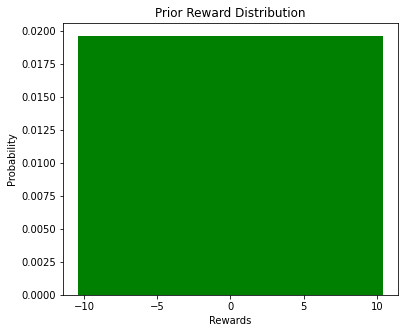

In [8]:
plt.rcParams['figure.figsize'] = (6,5)
plt.bar(support,p, color = 'green')
plt.ylabel('Probability')
plt.title('Initial Reward Distribution')
plt.xlabel('Rewards');

Note that we have two vectors: the ``support`` vector (which corresponds to all events with non-zero probability) and the ``p`` vector which holds the probabilities for the values in the support vector. 

### Locating the Reward Value

Because we want to construct a projection of the reward onto the support vector, we need to compute the index of the reward on that support vector.

Thus, our goal here will be to write some code that does this. 

Let us first fix some parameters and introduce a variable Z. Here we assume a $\gamma$ of 0.8.

In [9]:
gamma = 0.8
Z = p    # rename p to Z
N=51         # number of items/atoms in the support 

In the context of the categorical algorithm (see: algorithm above), what we want to do now is to compute the **Bellman Update** by gradually updating the components of the update (i.e. each atom $z_{j}$).

Suppose now that we are in a given state $x$ and that the $a_{\text{up}}$ is the action that yields the highest reward (of say, $5$). We need to find a way to project this value onto the support distribution. As such, the first step would be to *locate the index* of the reward value on the support vector.

Visually, first want to to locate the location of the reward. 

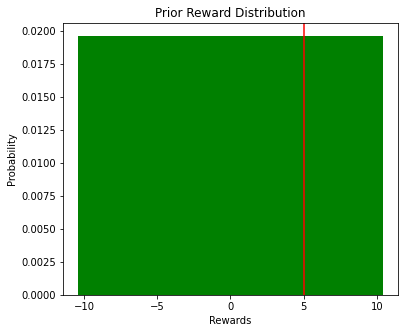

In [10]:
# Assume that for a given action, we get a reward of 5
observed_reward = 5
plt.bar(support,Z, color = 'green')
plt.ylabel('Probability')
plt.title('Initial Reward Distribution')
plt.axvline(x = observed_reward, color = 'r', label = 'axvline - full height')
plt.xlabel('Rewards');

Moreover, we observe that the spacing between the support values is 0.4. 

In [11]:
print(support)

[-10.   -9.6  -9.2  -8.8  -8.4  -8.   -7.6  -7.2  -6.8  -6.4  -6.   -5.6
  -5.2  -4.8  -4.4  -4.   -3.6  -3.2  -2.8  -2.4  -2.   -1.6  -1.2  -0.8
  -0.4   0.    0.4   0.8   1.2   1.6   2.    2.4   2.8   3.2   3.6   4.
   4.4   4.8   5.2   5.6   6.    6.4   6.8   7.2   7.6   8.    8.4   8.8
   9.2   9.6  10. ]


However, we do not have to need to rely on observation, but can also derive it using the following formula:

$$\large \Delta z = \frac{V_{MAX} - V_{MIN}}{N-1}, $$


where $\Delta z $ denotes the closeness between the elements in the support vector and $N$ the number of elements in the support vector. 

**Question 1**:  Verify that the space between each element is indeed 0.4 by implementing the equation above. Make sure that the variable name is ``dz``.

In [12]:
# Compute the projection of the update onto the support vector
# d(elta)z is the closest support element 
# YOUR CODE HERE
dz = (vmax-vmin)/(N-1.)
print(dz)

0.4


As a next step, we want to pinpoint exactly where the value $5$ falls on the support vector. It is highly likely that the observed reward will not fall exactly on one of the elements in the support vector. To reiterate, we need to find the *index* value of the ***closest* support element**, which we will call $b_{j}$.

We can use the following formula to find the closest support element:

$$\large b_{j} = \frac{r-V_{MIN}}{\Delta z},$$

where $r$ denotes the observed reward. 

**Quick sidenote:** For the sake of simplicity, contrary to what is stated in the algorithm, we replaced $\hat{T}z_{j}$ by $r$).

**Quick sidenote:** Note that $b_{j}$ can take on any value in the support vector. In this case, $b_{j} \in [0, N - 1].$

**Question 2:** Implement the equation above. Make sure that $b_{i} \in \mathbb{Z}$ (i.e. make sure that $b_{i}$ has an integer value). Also make sure to name the variable ``bj``.

In [13]:
# compute bj, the index value of the support vector 
# YOUR CODE HERE

bj = np.round((observed_reward-vmin)/dz) 
bj = int(bj)

Evaluate the value of ``bj``. Does it correspond to the location of the reward ``5`` in the plots above? 

In [14]:
print(bj)

38


### Updating the Probability Vector

Because it is convenient to keep a copy of the original distribution, we create a copy of the original ``p`` vector and call it ``probabilities``.

In [37]:
probabilities = p.copy()
print(probabilities)

NameError: name 'p' is not defined

Every time the agent encounters a reward, we update the distribution of the action that yields the highest reward. 

One way to think of this is that probability mass is shifted from the left and right sides of the reward value to the value of the observed reward. In other words, probability mass gets *redistributed* towards the centre of mass.  This is the second step in the algorithm. 

As illustrated below, our goal here is to update the uniform distribution by gradually moving mass to the centre of mass, both from the left side and from the right side. 

![alt text](img/bayes.png "Title")

We can think about this procedure in more Bayesian terms (N.B. the procedure itself is not Bayesian), our belief is that $5$ is representative of the actual reward structure in the environment is being *reinforced*. This means that all other values are *less likely* and that observing a $5$ is *more likely*. 

By now it should become clear why computing the index of the support vector was so important: we need it to determine *where*, on the probabilities vector, we need to move the mass to. 

As such, in a way, the ``support`` acts as our sample space and the ``p`` (or ``Z``) vector keeps track the probabilities of the support elements. 

Thus, in the context of approximate distributional reinforcement learning, **updating the target distributions** refers to the agent making an update to the empirical reward distribution each time it receives a reward. In doing so, it strengthens its belief for a certain action. 

Now, for each point in the probabilities vector (remember, there are 51 items in that vector), we gradually want to update the values by stealing some mass from its immediate neighbor. 

To make things a bit more precise, we will follow a two-step procedure:

1. We will steal mass from the neighbors left of $b_{j}$.

2. We will steal mass from the neighbors right of $b_{j}$.

Let us consider a couple of cases of "mass-stealing" for the neighbors **left** of $b_{j}$, which we can formalize as:

$$ \large m^{i}_{l} \leftarrow m^{i}_{l} + \gamma^{j} m^{i-1}_{l},$$

where $m_{l}^{i}$ denotes the probability mass of the value we want to update, $\gamma^{j} m^{i-1}_{l}$ how much we steal from its neighbor on the left and $\gamma^{j}$ denotes the discount factor with an index $j$ (this tells us how far we are removed from the centre of mass - the further away from $b_{j}$ the fewer mass is being stolen).


Important to note here is that *each* value of the distributions is being updated. As can be seen in the formula, the update always contain the value of $m^{i}_{l}$ itself plus a discounted update term, $\gamma^{j} m^{i-1}_{l}$. 

**Question 3:** Consider the following loop and observe how the value changes for different values of ``gamma``. How does the output changes for ``gamma = 1``, ``gamma = 0.8`` and ``gamma = 0.4``? And what happens as ``j`` increases? 

In [16]:
gamma = 0.4

for j in range(1, 5):
    print(f'j: {j}. Value for second term: {np.round(np.power(gamma, j), 2)}.')

j: 1. Value for second term: 0.4.
j: 2. Value for second term: 0.16.
j: 3. Value for second term: 0.06.
j: 4. Value for second term: 0.03.


The values around the observed reward value $r$ are more likely than values further down the line (e.g. if we observe 5, then 4 is more likely to be observed than -10). As such, we want to update each of the values in the probabilities vector.

Let us look at a couple of examples. First, let us look at what an update of the value for $r=5$, which, as we computed, is located at $b_{j} = 38$, would look like. 

In [17]:
# print probability for reward observation
print(probabilities[38])

0.0196078431372549


In [18]:
gamma = 0.8
j = 1       # j indicates how far we are removed from the centre of mass bj
updated_val = probabilities[38] + ((gamma**j) * probabilities[38-1])
print(updated_val)

0.03529411764705882


As can be seen, the new *probability value* at index *38* is now ~0.035 instead of ~0.020. 

Let us consider the next value. 

In [19]:
j = 2       # j indicates how far we are removed from the centre of mass bj
updated_val = probabilities[37] + ((gamma**j) * probabilities[37-1])
print(updated_val)

0.03215686274509804


Note that the new value is ~0.032. As can be seen, the index parameter *j* reduces the amount of mass shifted from one point to the next. 

**Question 4:** Now it is your turn. Write a for loop that gradually updates each of the values on the *left* side of the centre of mass at $b_{j}$. Make sure to update the values in the ``probabilities`` vector.

In [20]:
# redistribute probability mass for each of the values on the left side to the observed reward value
# YOUR CODE HERE
j = 1

for i in range(bj,1,-1):
    probabilities[i] += np.power(gamma,j) * probabilities[i-1]
    j += 1

Verify the output. You should observe a step-pattern on the left side of $b_{j} = 38$. As you can imagine, we also want to update the points on the right of the centre of mass. 

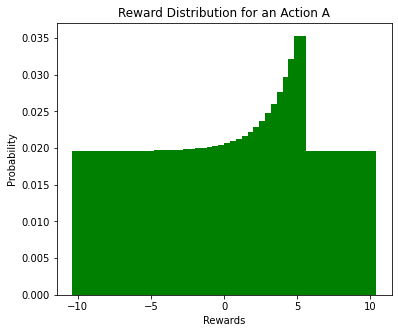

In [21]:
plt.bar(support,probabilities, color = 'green')
plt.title('Reward Distribution for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

**Question 5:** Update the points on the *right* side using the following update rule:

$$ \large m^{i}_{r} \leftarrow m^{i}_{r} + \gamma^{j} m^{r+1}_{r},$$

where $m_{r}^{i}$ denotes any point on the right of $b_{j}$.

In [22]:
# redistribute probability mass for each of the values on the left side to the observed reward value
# YOUR CODE HERE
j = 1
for i in range(bj,N-1,1):
    probabilities[i] += np.power(gamma,j) * probabilities[i+1]
    j += 1

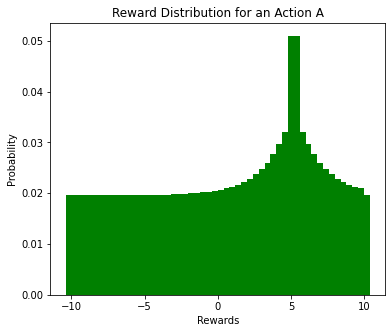

In [23]:
plt.bar(support,probabilities, color = 'green')
plt.title('Reward Distribution for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

Because we are dealing with a probability distribution, check if the sum still equals 1. If this is not the case, normalize the output. 

In [24]:
# YOUR CODE HERE
probabilities /= probabilities.sum() 
print(probabilities.sum())

1.0


Run the code below. You should see a mode around the reward value of $5$, with a step pattern on both sides of this value. 

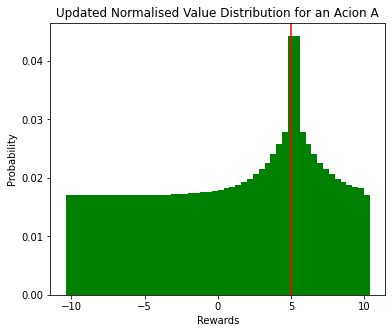

In [25]:
plt.bar(support,probabilities, color = 'green')
plt.title('Updated Normalised Value Distribution for an Acion A')
plt.ylabel('Probability')
plt.axvline(x = observed_reward, color = 'r', label = 'axvline - full height')
plt.xlabel('Rewards');

We have now created all the necessary building blocks to build an updater function, which we will call ``update_dist``. 

**Question 6:** Combine all the individual pieces of code into a function that returns the updated distribution. Please do not change the input parameters. Moreover, make sure that the function returns the *entire* updated distribution. 

- Hint: You can reuse *all* your code from before - no need to write any new code. 

In [26]:
def update_dist(observed_reward, support, probabilities, vmin, vmax, gamma=0.8):
    """Function that updates the input distribution in accordance with observed reward.

    Args:
        observed_reward (int): Reward observed after taking some action.
        support (torch.Tensor): Support vector.
        probabilities (torch.Tensor): Probability vector. 
        vmin (float): Lower bound of the support.
        vmax (float): Upper bound of the support.
        gamma (float): Discount factor. 

    Returns:
        probabilitiesprobabilitiesposterior.
    """
    # YOUR CODE HERE
    N = probabilities.shape[0]
    dz = (vmax-vmin)/(N-1.)
    bj = int(np.round((observed_reward-vmin)/dz))
    #bj = int(np.clip(bj,0,N-1)) 
    probabilities = probabilities.copy()
    j = 1
    for i in range(bj,1,-1): 
        probabilities[i] += np.power(gamma,j) * probabilities[i-1]
        j += 1
    j = 1
    for i in range(bj,N-1,1): 
        probabilities[i] += np.power(gamma,j) * probabilities[i+1]
        j += 1
    probabilities /= probabilities.sum() 
    return probabilities

Run the code below and evaluate the output. Does it cluster around the observed reward value?

In [27]:
observed_reward = 5    # set hypothetical reward
number_of_obs = 10     # set the number of observations
Z = p              # initialise Z

for i in range(number_of_obs):
    Z = update_dist(observed_reward,support,Z,vmin,vmax,gamma=0.8)

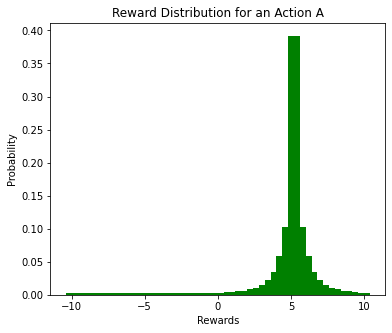

In [28]:
plt.bar(support,Z, color = 'green')
plt.title('Reward Distribution for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

Note that the more often a certain reward is received by the agent, the higher the tendency to cluster around one value (or values, as we will see in a bit). As such, the variance decreases with more observations. 

Consider the code below. We now have a more complicated reward structure. Does it cluster around the various modes?

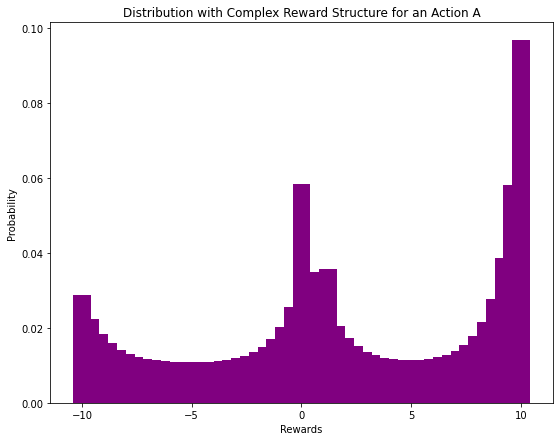

In [29]:
Z = p
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], support, Z, vmin,vmax, gamma=0.7)

plt.figure(figsize=(9,7))
plt.bar(support, Z, color = 'purple')
plt.title('Distribution with Complex Reward Structure for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

As can be seen, the reward structure is more complicated in this scenario. This can be hugely beneficial in the context of reinforcement learning because the agent can now make a more nuanced decision. 

In this specific case, sometimes the action gives a reward of 0, most of the time a reward of 10, but a reward of -10 is also quite likely. This cannot be modelled by a "classical reinforcement" learner. For instance, if we just take the mean, we would think that this action yields a much lower reward.

In [30]:
np.mean(ob_rewards)

3.1

Furthermore, incorporated within this distribution is a risk-reward trade-off. Sometimes taking this action may yield +10, but it may sometimes also lead to a catastrophic failure (i.e. if we get -10). The "classical" agent may not infer this from a simple *mean* reward of 3.1. 

## Selecting an Action: Collapse of the Reward Distribution

We have been implementing an updating procedure for one single action. Let us now consider consider a hypothetical scenario where we play a game with 3 actions. The reward structures that the agent received under some policy $\pi$ are defined as follows :

In [31]:
ob_rewards1 = [10,10,10,0,1,0,-10,-10,10,10]
ob_rewards2 = [5,5,5,1,5,4,5,5,5,5]
ob_rewards3 = [-4,-3,-4,0,-2,-4,-4,-3,-5,-5]

For each of the actions, we defined a ``Z``. As before, our initial will be a simple, uniform distribution with a support of 51. 

In [32]:
probabilities = np.ones(51)
probabilities = probabilities / probabilities.sum()
probabilities

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

We can now define three initial distributions over the actions spaces, $Z_{1}$, $Z_{2}$ and $Z_{3}$ - three distributions we need to update. 

In [33]:
Z1, Z2, Z3 = p, p, p

As before, we can loop over the update function. Now, however, we do this for each of the three actions.

In [34]:
for i in range(len(ob_rewards1)):
    Z1 = update_dist(ob_rewards1[i], support, Z1, vmin,vmax, gamma=0.7)
    Z2 = update_dist(ob_rewards2[i], support, Z2, vmin,vmax, gamma=0.7)
    Z3 = update_dist(ob_rewards3[i], support, Z3, vmin,vmax, gamma=0.7)

Let us visualize three distributions for the 3 actions.

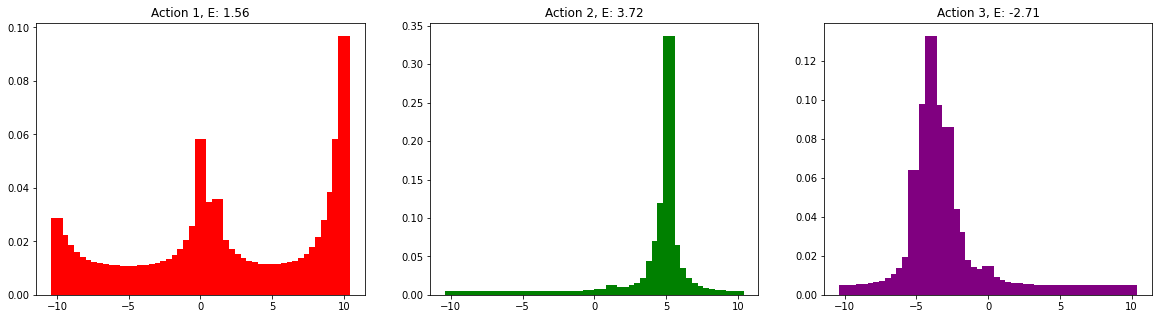

In [35]:
plt.rcParams['figure.figsize'] = (20,5) 

#The below code will create two plots. The parameters that .subplot take are (row, column, no. of plots).
plt.subplot(1,3,1)
action1 = plt.bar(support, Z1, color = 'red')
plt.title(f'Action 1, E: {np.round(support @ np.array(Z1), 2)}')
plt.subplot(1,3,2)
action2 = plt.bar(support, Z2, color = 'green')
plt.title(f'Action 2, E: {np.round(support @ np.array(Z2), 2)}')
plt.subplot(1,3,3)
action3 = plt.bar(support, Z3, color = 'purple')
plt.title(f'Action 3, E: {np.round(support @ np.array(Z3), 2)}')
plt.show()

As can be seen, we have 3 distributions. Each of these corresponds to the estimated distribution of rewards. In other words, based on $n$ observations, taking the action $A_{1}$ yields $Z_{1}$, $A_{2}$ yields $Z_{2}$ and $A_{3}$ yields $Z_{3}$. 

Because we are working with distributions over the action space, let us combine $Z_{1}$, $Z_{2}$ and $Z_{3}$ into a 3 by 51 array. 

In [ ]:
dist = np.array([Z1, Z2, Z3])
dist.shape

Selecting an action $a'$ from the set of possible actions on the next step can be formalised as follows:

$$\large \underset{a' \in \mathcal{A}}{\text{argmax}} \mathbb{ E } [Z(x', a')].$$

Thus, we select the action that maximizes the expected value. 

**Question 7:** Write a piece of code that selects, from these three actions (i.e. ``Z1, Z2, Z3``), the best one. 

- Hint 1: As discussed in the beginning, the expectation can be computed as the dot product of the support vector and its corresponding probabilities ``expected_value = probs @ outcomes``.
- Hint 2: First compute the expectation for each of the actions, then select the action with the highest reward.
- Hint 3: Use the formula above.

In [ ]:
def get_action(dist,support):
    # YOUR CODE HERE
    """This function returns an integer action in [0,1,2].
    
    Args: 
        dist (np.array): Input is a Ax51 array.
        support (np.array): Support vector.

    Returns:
        actions (int): vector of integers in {0,1,2}, dimension dist.shape[0] 
    """
    
    actions = []

    for i in range(dist.shape[0]):
        expectation = support @ dist[i]
        actions.append(expectation)                  # append action
        
    action = int(np.argmax(actions))                 # select action with highest reward
    
    return action


In [ ]:
get_action(dist,support)

As can be seen, based on the distributions, we should select action 1. 

## Distributional Deep Reinforcement Learning

We will now implement an actual game, Atari Freeway. As said before, the goal of this game is the run across a highway and gain as many points as possible. If you get hit by a car, you are being pushed back. If you reach the other side, you will get a reward of 1. Watch a couple of minutes of the clip below for a visual demonstration. 

<img src="img/freeway.gif" width="750" align="center">

We will now have a look at a Distributional DQN implementation of the Atari Freeway Game. We will start with a couple of functions. Some are given, and some require you to complete a line of code. 

To simulate the environment, we will make use of OpenAI ``gym``. Have a look at the actions. 

In [ ]:
env = gym.make('Freeway-ram-v0') 
aspace = 3                          # action space size
env.env.get_action_meanings()    

Let us now set the other hyperparameters.

In [ ]:
vmin,vmax = -10,10
replay_size = 200
batch_size = 50
N = 51
gamma = 0.1
episodes = 2000

Let us now initialise the network parameters. Note that we did not include the network in this notebook. If you are interested you can check out the network in the ``dist_dqn.py``-file.

**Question 8 (Bonus):** Run the trainer. 

We can now train the model by calling the trainer function. This function returns $\theta$, ``theta``, the parameters of the neural network and the ``losses``, which are the losses over time. The exact workings of this function are beyond the scope of this session, but you are encouraged to check out the code yourself (to be found in the ``trainer.py`` file).

In [ ]:
# start training
theta, losses = trainer(env, aspace, N, vmin, vmax, gamma, episodes)

Let us now visualize the loss over time. 

In [ ]:
plt.plot(losses) 
plt.title('Cross Entropy Loss over Time for the Atari Freeway Agent')
plt.ylabel('Loss')
plt.xlabel('Episode');

We can also observe how the agent is doing. Run the cell below to generate a visualization of the DistQN agent playing a game of Atari Freeway.

In [ ]:
# create empty list, to be populated by frames
clip = []

# reset the game
state = preproc_state(env.reset())
for i in range(1000):
    if i % 100 == 0:
        print(f"Rendering: {(i/1000)*100}% complete...")
    
    # make a prediction for a given state
    pred = dist_dqn(state,theta,3)
    # get the image
    image = get_dist_plot(env,pred,support,shape=(210,160,3))
    #pred = pred.detach.numpy()
    # select best action
    action = get_action_dqn(pred.unsqueeze(dim=0).detach().numpy(),support).item()
    # get state, reward and information
    s,r,d,j = env.step(action)
    # preprocess new state
    state = preproc_state(s)
    # append individual frames
    clip.append(image)
    
print('Rendering complete! Converting to mp4...')

# write to mp4
imageio.mimwrite('img/AtariHighway-v3.mp4', clip, fps = 20)

print('Done!')

**Question 9 (Bonus):** Consider the clip below. Explain the behaviour of the agent using the distribution on the right-hand side of the game. 

In [36]:
%%HTML
<video width='600' height='500' controls>
  <source src='img/AtariHighway-v2.mp4' type='video/mp4'>
</video>

# References 

- [A Distributional Perspective on Reinforcement Learning, Bellemare et.al. (2017)](https://arxiv.org/pdf/1707.06887.pdf)
- *Deep Reinforcement Learning in Action*, Zai & Brown 2020.
- [Deep Reinforcement Learning in Action, Zai & Brown, Github Repository](https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction)
- [Distributional Reinforcement Learning, Bellemare, Dabney and Rowland (2022, draft)](https://www.distributional-rl.org)
- [Distributional Reinforcement Learning with Quantile Regression, Dabney et.al. (2017)](https://arxiv.org/abs/1710.10044)
